# Saving logits of original and adversarially attacked inputs

The "hack" below allows absolute path imports as if the notebook was a py-file run with `python -m abs.path.to.file.filename`

In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)

In [2]:
print(root_dir)

/Users/gunder/Desktop/bachelor_project/


### Imports

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

from models.classifier32 import classifier32

from our_modules.tin_tools import get_avg_osr_auroc_across_splits
from our_modules.tin_tools import transform_range as tin_clip_range
from our_modules.tin_tools import save_grad_norms_across_splits
from our_modules.tin_tools import save_informed_attack

from our_modules.adv_tools import fp_osr_fgsm, fn_osr_fgsm, fp_osr_fgsm_sum_exp, fn_osr_fgsm_log_msp, fn_osr_fgsm_sum_exp, fn_osr_fgsm_max, fp_osr_fgsm_max
from our_modules.adv_tools import log_msp_loss
from our_modules.adv_tools import fp_osr_itat, fn_osr_itat, fp_osr_itat_max, fn_osr_itat_max
from our_modules.adv_tools import norm_loss



### Setting the Device

In [4]:
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

device: mps


## tiny-imagenet

In [5]:
path_to_pretrained_weights_folder = root_dir + "pretrained_weights/"
tin_val_root_dir = root_dir + "datasets/tiny-imagenet-200/val/images/"
tin_logits_dir = root_dir + "logits/tinyimagenet/"
tin_grad_norms_dir = root_dir + 'grad_norms/tinyimagenet/'

### Saving plain logits

In [6]:
#get_avg_osr_auroc_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, device, logdir=tin_logits_dir + "plain/")

### Savining Advesarial Attacks Logits

#### FGSM for different epsilon

##### FN

In [7]:
# eps = np.array([1.2, 1.4, 1.6, 1.8, 2.0, 2.25, 2.50, 2.75, 3.0, 4.0])
# eps = list(np.linspace(0.11,0.19,5))
epsfn = [float(name[4:]) for name in os.listdir(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm')]
epsfp = [float(name[4:]) for name in os.listdir(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm')]

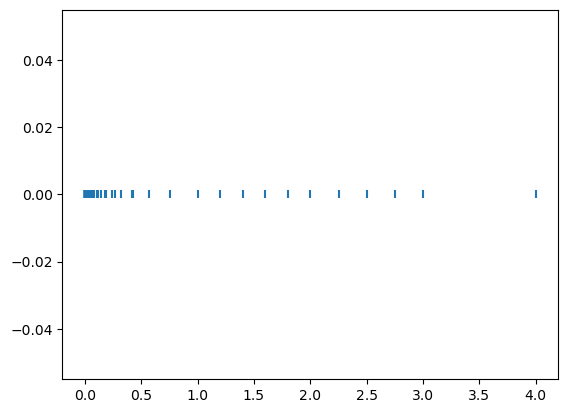

In [8]:
fig, ax = plt.subplots(1,1)
ax.scatter(epsfn, np.zeros_like(epsfn), marker ='|')
plt.show()

In [9]:
#fgsm_eps_experiment(eps, fn_osr_fgsm, tin_logits_dir + "fn/fgsm/", 1)

In [10]:
def eps_experiment(eps_list, eps_attack, logdir, number_of_splits=5, **eps_attack_kwargs):
    for eps in eps_list:
        attack = (lambda yhat, y, model: eps_attack(model, yhat, eps=eps, clip_range=tin_clip_range, **eps_attack_kwargs))
        get_avg_osr_auroc_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, device, logdir + f"eps_{eps:.3}/", adv_attack=attack, number_of_splits=number_of_splits, batch_size=100)


In [19]:
# eps_experiment(eps_list=eps, fgsm=fp_osr_fgsm, logdir=tin_logits_dir + "fp/fgsm/two_norm/", number_of_splits=1, norm_ord=None)
# eps_experiment(eps_list=eps, fgsm=fp_osr_fgsm, logdir=tin_logits_dir + "fp/fgsm/inf_norm/", number_of_splits=1, norm_ord=torch.inf)
# eps_experiment(eps_list=eps, fgsm=fp_osr_fgsm_sum_exp, logdir=tin_logits_dir + "fp/fgsm/sum_exp/", number_of_splits=1)
# eps_experiment(eps_list=eps, fgsm=fn_osr_fgsm, logdir=tin_logits_dir + "fn/fgsm/inf_norm/", number_of_splits=1, norm_ord=torch.inf)
# eps_experiment(eps_list=eps, eps_attack=fn_osr_fgsm_log_msp, logdir=tin_logits_dir + "fn/fgsm/log_msp/", number_of_splits=1)
# eps_experiment(eps_list=eps, fgsm=fn_osr_fgsm_sum_exp, logdir=tin_logits_dir + "fn/fgsm/sum_exp/", number_of_splits=1)
# eps_experiment(eps_list=eps, eps_attack=fn_osr_fgsm, logdir=tin_logits_dir + "fn/fgsm/two_norm/", number_of_splits=1, norm_ord=None)
eps_experiment(eps_list=epsfn, eps_attack=fn_osr_fgsm_max, logdir=tin_logits_dir + "fn/fgsm/max/", number_of_splits=1)
eps_experiment(eps_list=epsfp, eps_attack=fp_osr_fgsm_max, logdir=tin_logits_dir + "fp/fgsm/max/", number_of_splits=1)


100%|██████████| 1/1 [01:32<00:00, 92.34s/it]


### Saving Grad Norms 
Testing Odin paper

In [19]:
#save_grad_norms_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, tin_grad_norms_dir + 'log_msp/', log_msp_loss, device, number_of_splits=5)

### Informed Attack

In [11]:
save_informed_attack(tin_logits_dir + 'informed/fgsm/exp1/',
                     tin_logits_dir + 'fn/fgsm/max/eps_0.0737/', 
                     tin_logits_dir + 'fp/fgsm/two_norm/eps_0.0622/', 0)
save_informed_attack(tin_logits_dir + 'informed/fgsm/exp2/', 
                     tin_logits_dir + 'plain/', 
                     tin_logits_dir + 'fp/fgsm/two_norm/eps_0.0622/', 0)
save_informed_attack(tin_logits_dir + 'informed/fgsm/exp3/',
                     tin_logits_dir + 'fn/fgsm/max/eps_0.0737/', 
                     tin_logits_dir + 'plain/', 0)

## Saving Iterative Attacks

In [12]:
# eps_experiment([0.139], eps_attack=fn_osr_itat, logdir=tin_logits_dir + 'fn/itat/inf_norm/', norm_ord=torch.inf, max_iter=25, step_sizes=(1e-06, 1), number_of_splits=1)
# eps_experiment([0.0622], eps_attack=fp_osr_itat, logdir=tin_logits_dir + 'fp/itat/two_norm/', norm_ord=None, max_iter=25, step_sizes=(1e-06, 1), number_of_splits=1)
eps_experiment([0.0737], eps_attack=fn_osr_itat_max, logdir=tin_logits_dir + 'fn/itat/max/', max_iter=25, step_sizes=(1e-06, 1), number_of_splits=1)

  0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.9/site-packages/torch/optim/rprop.py:204: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  sign[sign.gt(0)] = etaplus
100%|██████████| 1/1 [56:14<00:00, 3374.70s/it]


In [13]:
save_informed_attack(tin_logits_dir + 'informed/itat/exp1/',
                     tin_logits_dir + 'fn/itat/max/eps_0.0737/', 
                     tin_logits_dir + 'fp/itat/two_norm/eps_0.0622/', 0)
save_informed_attack(tin_logits_dir + 'informed/itat/exp2/', 
                     tin_logits_dir + 'plain/', 
                     tin_logits_dir + 'fp/itat/two_norm/eps_0.0622/', 0)
save_informed_attack(tin_logits_dir + 'informed/itat/exp3/',
                     tin_logits_dir + 'fn/itat/max/eps_0.0737/', 
                     tin_logits_dir + 'plain/', 0)